In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

**Creating Custom dataset having 3 categories from CIFAR100**


In [2]:
from torchvision.datasets import CIFAR10

# Load CIFAR100 dataset
cifar10_train = CIFAR10(root='./data', train=True, download=True)



100%|██████████| 170498071/170498071 [00:01<00:00, 85363812.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# Print category numbers and classes
for category_number, class_name in enumerate(cifar10_train.classes):
    print(f"{category_number}: {class_name}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [4]:
# Custom categories i have considered [cat,deer,dog]
custom_categories = [3,4,5]


In [5]:
# Filter data based on custom categories
custom_dataset = [(img, label) for img, label in cifar10_train if label in custom_categories]


**Count of images in each category**

In [6]:
# Store and print the count of each category
category_count = {category: 0 for category in custom_categories}

for _, label in custom_dataset:
    category_count[label] += 1

for category, count in category_count.items():
    print(f"Category {category}: {count} images")

Category 3: 5000 images
Category 4: 5000 images
Category 5: 5000 images


**Split this data between 80% training and 20% test**

In [7]:
#Split data between 80% training and 20% test
dataset_size = len(custom_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_data, test_data = random_split(custom_dataset, [train_size, test_size])



In [8]:
len(train_data)

12000

In [9]:
len(test_data)

3000

**Preprocess the data as you see fit**

In [10]:
# Calculate mean and standard deviation for normalization
def calculate_mean_std(dataset):
    # Assuming dataset is a list of (image, label) tuples
    images = [image for image, label in dataset]
    stacked_images = torch.stack([transforms.ToTensor()(image) for image in images], dim=0)
    mean = stacked_images.mean(dim=(0, 2, 3))
    std = stacked_images.std(dim=(0, 2, 3))
    return mean, std

# Calculate mean and std for the training dataset
mean, std = calculate_mean_std(train_data)
print("Mean:", mean)
print("Std:", std)

# Apply normalization to the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Apply transformations to the datasets
train_dataset = [(transform(image), label) for image, label in train_data]
test_dataset = [(transform(image), label) for image, label in test_data]


Mean: tensor([0.4886, 0.4619, 0.4030])
Std: tensor([0.2425, 0.2350, 0.2408])


**# Step 4: Create a Convolutional Neural Network model**

In [11]:
import torch.nn.functional as F

class CNN_model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 custom categories

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Train the CNN model**

In [12]:
# Train DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Map CIFAR-10 labels to continuous range [0, num_classes-1]
label_mapping = {label: i for i, label in enumerate(custom_categories)}


# Initialize the model, loss function, and optimizer

num_classes = len(custom_categories)

# Initialize the model with the correct number of classes
cnn_model = CNN_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)


# Train the model
for epoch in range(10):  # Number of epochs
    for inputs, labels in train_loader:
      # Remap labels to continuous range [0, num_classes-1]
        labels = torch.tensor([label_mapping[label.item()] for label in labels])

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


**Make predictions on the test data and compare them to the expected categories**

In [14]:
def denormalize(image):
    mean = np.array([0.4885, 0.4617, 0.4028])
    std = np.array([0.2422, 0.2348, 0.2406])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

In [29]:
# Choose a specific image index to visualize
specific_index = 0

  0%|          | 0/94 [00:00<?, ?it/s]

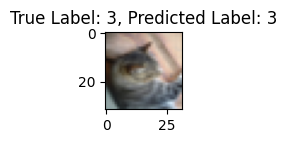

100%|██████████| 94/94 [00:01<00:00, 59.89it/s]


Test Accuracy: 71.00%


In [30]:
from tqdm import tqdm

#Define Test Dataloader

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

cnn_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(test_loader)):
        labels = torch.tensor([label_mapping[label.item()] for label in labels])
        outputs = cnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i == specific_index:
            # Visualize the specific test image
            img = denormalize(inputs[0].permute(1, 2, 0).numpy())  # Denormalize before changing to numpy array
            true_label = custom_categories[labels[0].item()]
            predicted_label = custom_categories[predicted[0].item()]

            plt.figure(figsize=(1,1))
            plt.imshow(img)
            plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
            plt.show()

accuracy = correct / total
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')




**Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.**

In [31]:
from torchvision import models

class GoogleNetWithLinear(nn.Module):
    def __init__(self, num_classes):
        super(GoogleNetWithLinear, self).__init__()
        self.googlenet = models.googlenet(pretrained=True, aux_logits=True)
        in_features = self.googlenet.fc.in_features
        self.googlenet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.googlenet(x)

# Initialize GoogleNet model, loss function, and optimizer
google_net_model = GoogleNetWithLinear(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(google_net_model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 193MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
 

In [32]:
from tqdm import tqdm

# Training
for epoch in range(10):
    google_net_model.train()
    for inputs, labels in tqdm(train_loader):
        labels = torch.tensor([label_mapping[label.item()] for label in labels])
        optimizer.zero_grad()
        outputs = google_net_model(inputs)
        logits = outputs.logits  # Access the logits from GoogLeNetOutputs
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

# Testing
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        labels = torch.tensor([label_mapping[label.item()] for label in labels])
        outputs = google_net_model(inputs)
        logits = outputs.logits
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_google_net = correct / total
print(f'\nGoogleNet Test Accuracy: {accuracy_google_net * 100:.2f}%')


100%|██████████| 94/94 [00:09<00:00, 10.37it/s]


GoogleNet Test Accuracy: 72.53%


Test Accuracy of CNN model is 71% whereas the test accuracy of GoogleNet model is 72.53%.


GitHub Link:   https://github.com/Priyanka-Bhyregowda/Deep-Learning